# VAR frecuentista
Seguiremos a [CEE2005](https://doi.org/10.1086/426038)

CEE2005 calculan los efectos de la política monetaria convencional (PMC), para ello asumen:
* Caracterización de la PMC: $$r_t = f(\boldsymbol{\Omega}_t) + \epsilon_t$$ donde $\Omega_t$ es el set de información utilizado por el BC para determinar la tasa de interés $R_t$

* Los agregados monetarios son tales que la ecuación de arriba se satisface

* Identificación: $\epsilon_t$ es ortogonal a $\boldsymbol{\Omega}_t$

* Definamos $\mathbf{X}^s=\{\mathbf{x}_i\}_{t=-\infty}^{s}$ la historia del vector $\mathbf{x}_i$ hasta el momento $s$, entonces $\boldsymbol{\Omega}_t$ es $$\boldsymbol{\Omega}^t\equiv\{\mathbf{Y}_1^{t}\ \mathbf{Y}_2^{t-1}\}$$

* El VAR se puede especificar como: $\mathbf{y}_t=[\mathbf{y}_{1,t}\ r_t\ \mathbf{y}_{2,t}]$ donde debido a que $\mathbf{y}_{1,t}\in \boldsymbol{\Omega}^t$, no responde a variaciones de $r_t$. Asimismo, como $\mathbf{y}_{2,t}\not\in \boldsymbol{\Omega}^t$, responde a variaciones de $r_t$.

Especificación:

$$\mathbf{y}_{1,t}=[gdp_t,\ cons_t,\ p_t^{def},\ inv_t,\ wage_t,\ labprod_t]'$$

$$\mathbf{y}_{2,t}=[profits_t,\ Growth^{M2}_t)]$$

Todas las variables en logaritmos naturales excepto $Growth^{M2}_t$

* Que tipo de identificación es esta?
* Importa el orden de las variables dentro de $\mathbf{y}_{1,t}$ e $\mathbf{y}_{2,t}$?

## Importar modulos requeridos

In [1]:
import numpy as np # Algebra matricial
import pandas as pd
import random      # Simulacion aleatoria
import matplotlib.pyplot as plt # gráficos
import os
import sys

Fijar la configuración para ejecutar este notebook

In [2]:
flag_runlocal  = True    # "False" para ejecutar en google colab
flag_useserver = True    # "False" para ejecutar con conexión a internet via proxy

In [3]:
if flag_runlocal:
    # ---> Ejecución local
    pathBayesInfer = ''
    if flag_useserver:
        from ConfigProxy import proxy
        # Set the proxy with authentication
        import os
        os.environ['http_proxy'] = proxy
        os.environ['https_proxy'] = proxy

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/Alledar/BayesInfer.git
    pathBayesInfer = '/content/BayesInfer/'

sys.path.append(pathBayesInfer+'02_Libraries')
import VARstuff

In [4]:
random.seed( 0 )    # Fijando la semilla (reproducir resultados)
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
cwd = os.getcwd()
sys.path.append(cwd)

In [5]:
import pandas_datareader.data as web
import datetime

## Carga de datos
con ```pandas_datareader``` podemos extraer los datos directamente de las bases de datos de la FED

In [6]:
start = datetime.datetime(1965,1,1)
end   = datetime.datetime(2004,12,31)
EFF  = web.DataReader('DFF', 'fred', start=start, end=end)
EFF  = EFF.resample('Q').mean()
index = EFF.index
RGDP = web.DataReader('GDPC1', 'fred', start=start, end=end)
CONS = web.DataReader('PCECC96', 'fred', start=start, end=end)
DEF  = web.DataReader('GDPDEF', 'fred', start=start, end=end)
RINV = web.DataReader('RINV', 'fred', start=start, end=end)
TLP  = web.DataReader('ULQELP01USQ661S', 'fred', start=start, end=end)
PRF  = web.DataReader('CP', 'fred', start=start, end=end)
M2   = web.DataReader('MABMM201USQ189S', 'fred', start=datetime.datetime(1964,9,1), end=end)
DM2  = (M2/M2.shift(1)).dropna()
CPI  = web.DataReader('CPALTT01USQ661S', 'fred', start=start, end=end)

RGDP.index = EFF.index
CONS.index = EFF.index
DEF.index = EFF.index
RINV.index = EFF.index
TLP.index = EFF.index
PRF.index = EFF.index
DM2.index = EFF.index
CPI.index = EFF.index

# Wages is downloaded from BLS as csv
RWAG = pd.read_csv(pathBayesInver + '03_Inputs/BLS_Wage.csv')
RWAG.index = RGDP.index

NameError: name 'pathBayesInver' is not defined

Transfomando la data

In [7]:
yy = np.log(RGDP)
cc =  np.log(CONS)
dd = np.log(DEF)
ii = np.log(RINV)
ww = np.log(RWAG)
lp = np.log(TLP)
rr = EFF
rp = pd.DataFrame(np.log(PRF.values/CPI.values))
rp.index = index
dm = np.log(DM2)

DF = pd.concat([ yy, cc,   dd,   ii, ww,  lp, rr,     rp,    dm],axis=1)
DF.columns =   ['y','c','def','inv','w','lp','r', 'prof', 'dm2']

data = DF.values
DF.head()

,y,c,def,inv,w,lp,r,prof,dm2
DATE,,,,,,,,,
1965-03-31,8.380711,7.868738,2.800629,5.918360,2.106570,3.896023,3.977222,1.345570,0.019790
1965-06-30,8.393267,7.879707,2.805237,5.938433,2.109364,3.898518,4.079451,1.375513,0.016515
1965-09-30,8.415255,7.896743,2.809101,5.971313,2.117460,3.913871,4.077500,1.390331,0.019316
1965-12-31,8.438033,7.924468,2.815947,6.006676,2.124654,3.930256,4.170761,1.440672,0.021659
1966-03-31,8.462080,7.939123,2.822331,6.054825,2.120703,3.949493,4.559000,1.458244,0.019050


# Estimar
Como en CEE2005 tomamos 4 rezagos (i.e., ```lag=4```) y construimos las matrices de acuerdo a sus definiciones en las diapositivas

In [8]:
lag = 4
y,X,k,Tf = VARstuff.get_yXform(data,lag)

Estimación MCO

In [9]:
Bhat,Sigmahat,yhat,uhat = VARstuff.get_MCO_VAR(y,X)

## Pronóstico
Utilizaremos la función que simula VARs para obtener pronósticos

* Si simulamos el VAR con punto inicial a las primeras $p$ observaciones en la data y con los residuos estimados, deberiamos replicar toda la data?

In [10]:
X0 = X[0,:]
yrep,Xrep = VARstuff.get_sim_VAR(X0,uhat,Bhat,lag)
np.linalg.norm(y-yrep)

1.692797535083938e-11

* Cortemos la muestra 2 años antes del fin de los datos para estimar

In [11]:
H = 2*4
yhist = y[:(Tf-H-1),:]
Xhist = X[:(Tf-H-1),:]
Bhat_hist,Sigmahat_hist,yhat_hist,uhat_hist = VARstuff.get_MCO_VAR(yhist,Xhist)

In [12]:
Xtp1 = X[(Tf-H-1),:] # Punto inicial para pronóstico

In [13]:
ytrue = y[(Tf-H-1):,:]
ytrue_first = np.reshape(ytrue[0,:],(1,k))

In [14]:
u_zero = np.zeros(shape=(H,k)) # sin choques en el horizonte de proyección
y_zero,_ = VARstuff.get_sim_VAR(Xtp1,u_zero,Bhat_hist,lag)
y_zero = np.r_[ytrue_first,y_zero]

In [15]:
yt = ytrue_first
n=10**3
Fore_BT = VARstuff.get_Fore_BT(yt,Xtp1,uhat_hist,Bhat,lag,H,n)

[                                                  ]
[--------------------------------------------------]



In [16]:
ForeBT_Q95  = np.percentile(Fore_BT, 95, axis=2)
ForeBT_Q05  = np.percentile(Fore_BT,  5, axis=2)
ForeBT_mean = np.mean(Fore_BT,axis=2)

In [17]:
quarters = 12.75+np.array(range(9))/4+0.125
varnames = ['PBI','Consumo','Deflactor','Inversion','Salarios','Labor Prod.','Tasa de interes', 'Utilidades', 'Crec. M2']

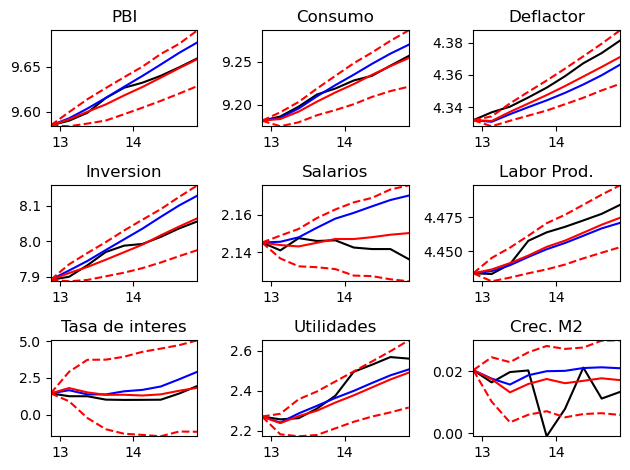

In [18]:
fig, axs = plt.subplots(3,3)

ff = 0
for rr in range(3):
    for cc in range(3):
        axs[rr,cc].plot(quarters,ytrue[:,ff],'k')
        axs[rr,cc].plot(quarters,y_zero[:,ff],'b')
        axs[rr,cc].plot(quarters,ForeBT_mean[:,ff],'r')
        axs[rr,cc].plot(quarters,ForeBT_Q05[:,ff],'--r')
        axs[rr,cc].plot(quarters,ForeBT_Q95[:,ff],'--r')
        axs[rr,cc].set_title(varnames[ff])
        axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
        ff += 1

plt.tight_layout()

## Impulso respuesta
Identificación por Cholesky

### IRF simple

In [19]:
h = 4*5    # 4 años
shock = 7  # 'r' en posición 7
scale = -1 # choque negativo de tasa (# de STDs)
IRF = VARstuff.get_IRF_Chol(Bhat,Sigmahat,h,shock,k,lag,scale)

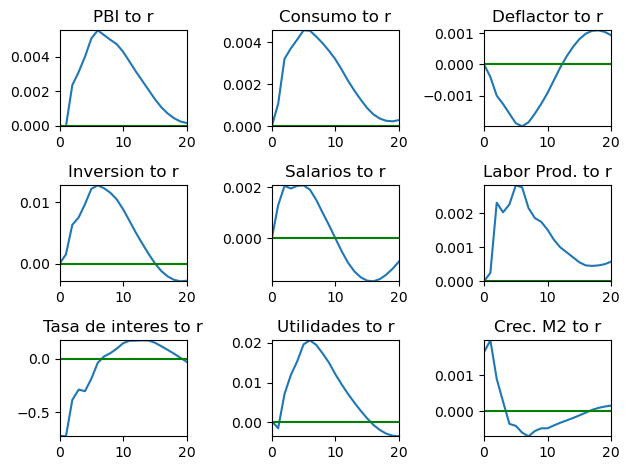

In [20]:
fig, axs = plt.subplots(3,3)

ff = 0
for rr in range(3):
    for cc in range(3):
        axs[rr,cc].plot(IRF[ff,:])
        axs[rr,cc].axhline(0, color='green')
        axs[rr,cc].set_title(varnames[ff]+' to r')
        axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
        ff += 1

plt.tight_layout()

### Intervalo de confianza: Bootstrap

In [21]:
nsample = 10**3
IRF_BT = VARstuff.get_IRF_Chol_BT(y,X,k,Tf,nsample,h,shock,lag,scale)

[                                                  ]
[--------------------------------------------------]



In [22]:
IRFBT_Q95  = np.percentile(IRF_BT, 95, axis=2)
IRFBT_Q05  = np.percentile(IRF_BT,  5, axis=2)
IRFBT_mean = np.mean(IRF_BT,axis=2)

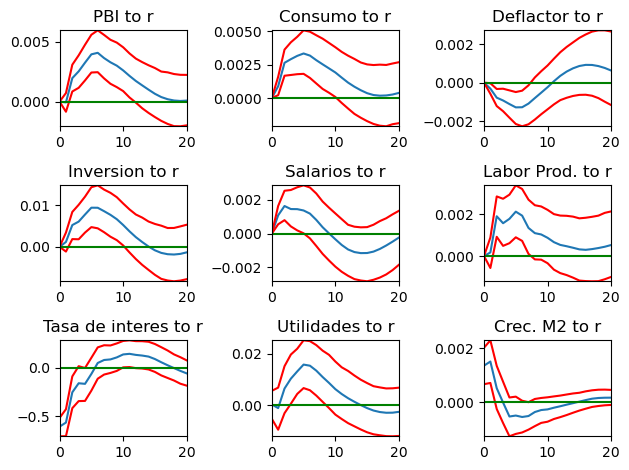

In [23]:
fig, axs = plt.subplots(3,3)

ff = 0
for rr in range(3):
    for cc in range(3):
        axs[rr,cc].plot(IRFBT_mean[ff,:])
        axs[rr,cc].plot(IRFBT_Q95[ff,:],'r')
        axs[rr,cc].plot(IRFBT_Q05[ff,:],'r')
        axs[rr,cc].axhline(0, color='green')
        axs[rr,cc].set_title(varnames[ff]+' to r')
        axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
        ff += 1

plt.tight_layout()

# Referencias

> Christiano, Eichenbaum and Evans, *Nominal Rigidities and the Dynamic Effects of a Shock to Monetary Policy*, Journal of Political Economy [https://doi.org/10.1086/426038](https://doi.org/10.1086/426038)

> Lütkepohl, Helmut, 2005. *New introduction to multiple time series analysis*. Springer Berlin Heidelberg. [https://www.springer.com/gp/book/9783540401728](https://www.springer.com/gp/book/9783540401728)